# Product Pricing Chart Case Study

- Product A has a raw material cost of around 7 and takes about 30 - 45 minutes of processing time to complete.
- Product starts at 35 dollars and vendor is charging 5 dollars for each additional color used in construction.

### Generating Test Data

- Product has 3 parameters which can be customized for each user basis. Length, Weight, and Color.
- In my generated test data I am maxing out on a length of 20 inches.

In [167]:
import matplotlib.pyplot as plt
# products start at $35 and cost $5 extra for each additional color
import numpy as np
import pandas as pd
# Initial values provided by client
MATERIAL_PRICE = 7
BASE_PRICE= 35
COST_PER_COLOR = 5
print(f"BASE PRICE: ${BASE_PRICE}")
print(f"COST PER COLOR: ${COST_PER_COLOR}")
print(f"MATERIAL PRICE: ${MATERIAL_PRICE}")
DEFAULT_LENGTH = 12
DEFAULT_WIDTH = 8
MATERIAL_LOSS = 8
INCHES_PER_UNIT = 15 * 12


BASE PRICE: $35
COST PER COLOR: $5
MATERIAL PRICE: $7


#### Generating Test Data for Analysis

In [168]:
# Generating test data
import pandas as pd

MAX_WIDTH = 12
MAX_LENGTH = 16
MAX_NUM_COLORS = 7
width_list = list(range(4, MAX_WIDTH + 1, 2))
length_list = list(range(6, MAX_LENGTH + 1))
color_list = list(range(1,MAX_NUM_COLORS + 1))
data = []

for color in color_list:
    for width in width_list:
        for length in length_list:
            # Removing invalid params from dataset
            if color < width:
                data.append([length, width, color])

# Order of columns changed
df = pd.DataFrame(columns=['length', 'width', 'num_colors'], data=data)

df.head()

,length,width,num_colors
0,6,4,1
1,7,4,1
2,8,4,1
3,9,4,1
4,10,4,1


#### Calculating Build Stats

In [169]:
# Adding building stats to df
generated_columns = ['get_segment_length', 'get_num_segments', 'get_num_units_raw']
df_build_stats = df.copy()
df_build_stats['get_segment_length'] = df['length'] + 8
df_build_stats['get_num_segments'] = df['width'] / 2
df_build_stats['get_segments_per_color'] = df_build_stats['get_num_segments'] / df['num_colors']
df_build_stats['get_total_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_build_stats['get_num_units_raw'] = df_build_stats['get_total_length'] / INCHES_PER_UNIT
df_build_stats['get_length_per_color'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']

#### Segment Length vs Material Count

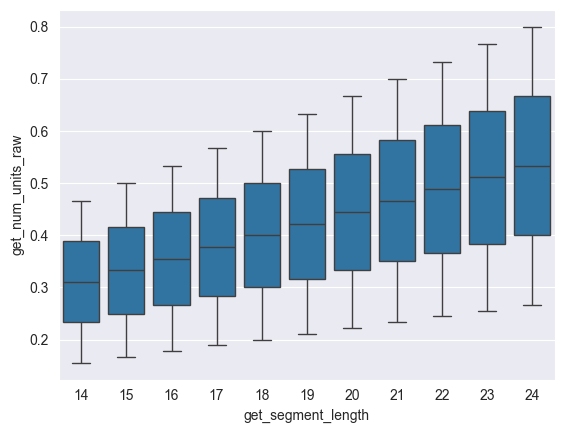

In [170]:
import seaborn as sns
sns.boxplot(data=df_build_stats, x='get_segment_length', y='get_num_units_raw')
plt.savefig("images/segment_length_vs_material_units.png")

### Profit Calculation 1

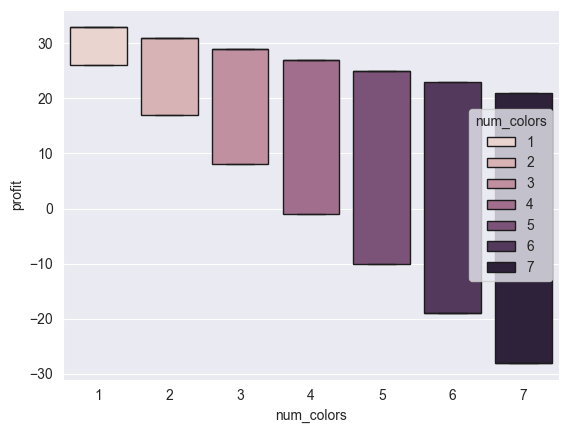

In [171]:
# Check if there is a profit margin in the worst case scenarios.
df_price0 = df.copy()
SHIPPING_PRICE = 7
COST_PER_UNIT = SHIPPING_PRICE + MATERIAL_PRICE
def calculate_profit(df_dimensions,  df_build, cost_per_unit):
    df_price = df_dimensions.copy()
    df_price['price'] = BASE_PRICE + df_price['num_colors'] * COST_PER_COLOR
    df_price['num_units'] = df_build['get_num_units_raw'].round(1) * df_build['num_colors']
    df_price['num_units_rounded'] = np.ceil(df_build['get_num_units_raw'] * 2) / 2 * df_build['num_colors']
    df_price['material_loss'] = df_price['num_units_rounded'] - df_price['num_units']
    df_price['material_length'] = df_build['get_segment_length'] * df_build['get_num_segments']
    df_price['material_cost']= df_price['num_units_rounded'] * cost_per_unit
    df_price['profit']= df_price['price'] - df_price['material_cost']
    return df_price
# Making copy of data for backup
df_price0 = calculate_profit(df_price0, df_build_stats, COST_PER_UNIT)
sns.boxplot(data=df_price0, x='num_colors', y='profit', hue='num_colors')
plt.savefig('images/num_colors_vs_profit0.png')


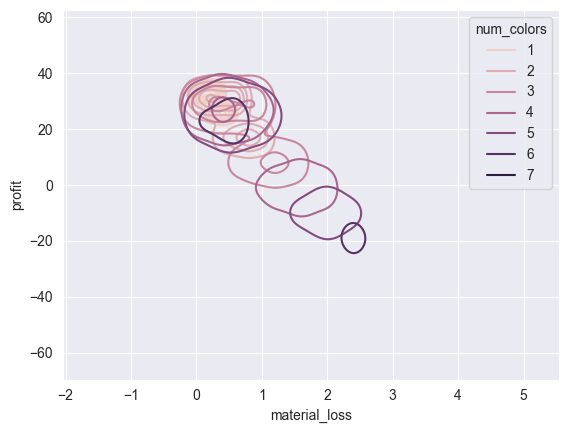

In [172]:
# Material loss vs profit 0
sns.kdeplot(data=df_price0, x='material_loss', y='profit', hue='num_colors')
plt.title=f"Material Loss vs Price Original (COST_PER_COLOR = {COST_PER_COLOR})"
plt.savefig("images/material_loss_vs_profit0.png")

In [173]:
# Copy df for final report numbering
df_price1 = df_price0.copy()

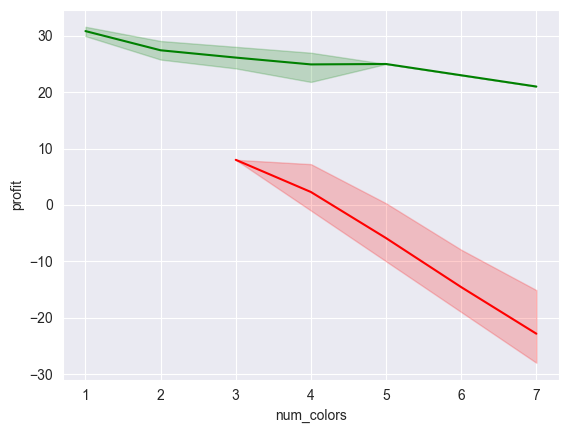

In [174]:
# If you remove the items with high material loss profit still goes down as number of colors increases but the value no longer goes negative.
df_low_material_loss = df_price0[df_price0['material_loss'] < 1]
df_high_material_loss = df_price0[df_price0['material_loss'] > 1]

sns.lineplot(data=df_low_material_loss, x='num_colors', y='profit', color='green')
sns.lineplot(data=df_high_material_loss, x='num_colors', y='profit', color='red')
plt.savefig("images/num_colors_vs_profit0_low_material_loss.png")
df_price2 = df_low_material_loss.copy()
# Green Low Material Loss items
# Red  high material loss items

#### Observations
- Initial price figures lead to profit going down as number of colors increases, but it doesn't go down for all orders.
- As Material loss goes up profit goes down.
- Some items in this set have stable material_loss as num_colors goes up.
#### Suggestions
- Vendor should remove items with high material loss from the store.
#### Other Notes
- Shipping and handling has a significant impact on final profit margins and may not have been calculated accurately in this chart.

### Material Loss Calculations

Material Loss: [$0.0 to $3.5]
Material Loss Mean: $0.82


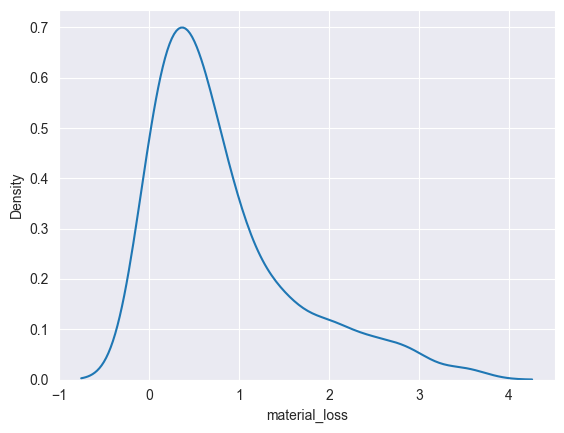

In [175]:
sns.kdeplot(data=df_price0, x='material_loss')
plt.savefig('images/material_loss_density.png')
print(f"Material Loss: [${df_price0['material_loss'].min()} to ${df_price0['material_loss'].max()}]")
print(f"Material Loss Mean: ${df_price0['material_loss'].mean().round(2)}")
# The mean material loss

#### Observations
- Most of the orders have a fairly low material_loss value
- The negative values for material loss are a artifact of the seaborn kde function.

#### Num Colors vs. Material Loss

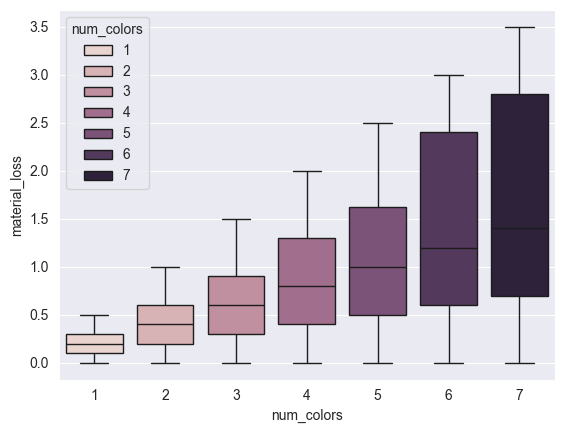

In [176]:
sns.boxplot(data=df_price0, x='num_colors', y='material_loss', hue='num_colors')
plt.savefig('images/material_loss_vs_num_colors.png')

##### Observations
- Orders with a large number of colors have high variability in their profit margin.
- As num_colors goes up material_loss goes up, but it doesn't go up uniformly across all orders.


#### Material Loss Scatter Plots

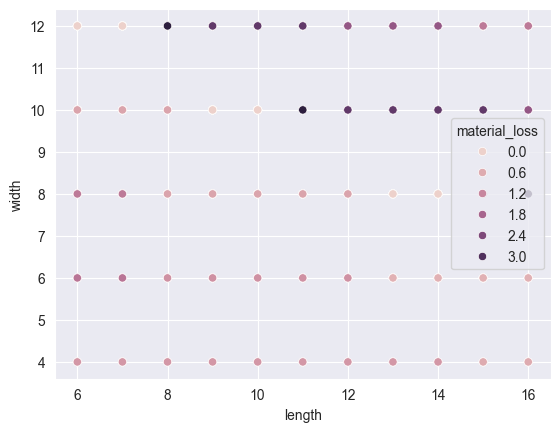

In [177]:
# Moving the material loss value back to original df for analysis
material_loss_columns = ['length', 'width', 'num_colors', 'material_loss']
df_build_stats['material_loss'] = df_price0['material_loss']

sns.scatterplot(data=df_build_stats[material_loss_columns], x='length', y='width', hue='material_loss')
plt.savefig("images/material_loss_ideal_dimensions.png")

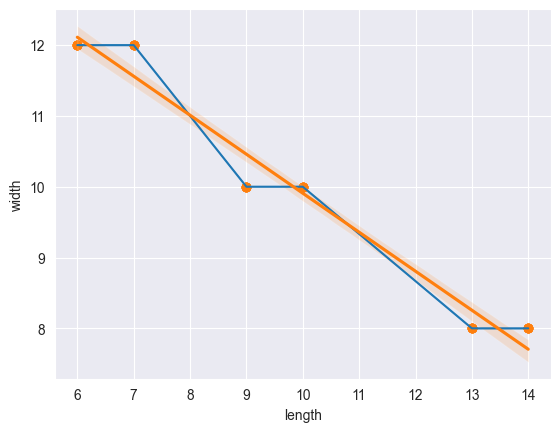

In [178]:
df_zero_loss = df_build_stats[df_build_stats['material_loss'] == 0]
sns.lineplot(data=df_zero_loss[material_loss_columns], x='length', y='width')
sns.regplot(data=df_zero_loss[material_loss_columns], x='length', y='width')
plt.savefig("images/ideal_dimensions_using_material_loss.png")


##### Observations
- For the optimal material_loss values length + width should be less than 19.
- If the customer only specifies one value in their request we can use this equation to calculate the other value.

## Filter Orders By Material Loss
We are using two equations to filter items by material loss
- Profit 2 includes all orders with material loss < 1
- Profit 3 includes all orders with length + width < 19
- Profit 2 requires an exact equation for material loss which makes it impractical to use in pricing scheme.

In [179]:
df_profit1 = df_price0
df_profit2 = df_price0[df_price0['material_loss'] < 1]
df_profit3 = df_price0[(df_price0['length'] + df_price0['width']) <= 19]

## Final Profit Comparisons

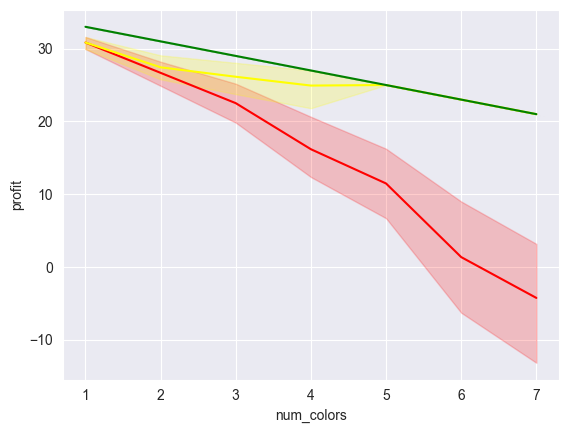

In [180]:
#Final profit comparisons
sns.lineplot(data=df_price1, x='num_colors', y='profit', color='red')
# Profit chart with material loss < 1
df_profit2 = df_price0[df_price0['material_loss'] < 1]
sns.lineplot(data=df_price2, x='num_colors', y='profit', color='yellow')
# Since material_loss may be hard to calculate on the fly we can use the length and width parameters instead
df_price3 = df_price0[(df_price0['length'] + df_price0['width']) <= 19]
sns.lineplot(data=df_price3, x='num_colors', y='profit', color='green')
plt.savefig("images/profit_chart_comparison.png")

### Price Ratings
- Red Line: color surcharge = \\$5 with no limits on order dimensions. (Price1)
- Yellow Line: color surcharge = \\$5 and material loss < 1 unit (Price2)
- Green Line: color surcharge = \\$5 and length + width == 19 (Price3)

#### Observations
- Of these 3 pricing schemes Price2, and Price3 are profitable while price1 is not.
- Pricing structure 2 and 3 are close enough that they can be used interchangeably.
- Pricing structure 3 is easier to calculate than pricing structure 2.
### Suggestions
- Client should charge \\$40 per item with a  \\$5 surcharge per additional color
- Client should limit orders to ones who's length and width <=19

In [181]:
#pricing_chart stats
df_price0.name="Price 1"
df_price2.name="Price 2"
df_price3.name="Price 3"

pricing_structures = [df_price0, df_price2, df_price3]
result_headers = ['Name', 'Min Profit', 'Max Profit', 'Mean Profit', 'Median Profit', 'size']
results = []
for structure in pricing_structures :
    results.append([
        structure.name, structure.profit.min().round(2), structure.profit.max().round(2), structure.profit.mean().round(2),structure.profit.median().round(2),
        structure.size])

df_results = pd.DataFrame(results, columns=result_headers)
df_results.head()

,Name,Min Profit,Max Profit,Mean Profit,Median Profit,size
0,Price 1,-28.0,33.0,17.31,25.0,3190
1,Price 2,-1.0,33.0,26.83,29.0,2230
2,Price 3,21.0,33.0,28.30,29.0,1540


## Client Suggestions
- Based on the profit vs num_color plots the optimal price for our products is \\$40 per order with a surcharge of \\$5 per color.
- Client should remove items with high material loss from the store by limiting product whose length and width add up to 19 to minimize material loss.

##### Author
- Product Profitability Report
- Daniel Levenstein
- Date: 09/16/2025